In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

plt.style.use('ggplot')
plt.style.use('seaborn-bright')

In [3]:
voice_usage_info = pd.read_excel("data/1.1 Voice Outgoing -Offnet-Onnet.xlsx")
voice_usage_info

,event_source.hash,call_count,call_duration,ym
0,be5b41e9fb315bac08b7e2faa3334d77,2.0,420.0,202104.0
1,fa4fd28eca6aa103ea9d74a9c099dbb4,7.0,600.0,202102.0
2,be5b41e9fb315bac08b7e2faa3334d77,1.0,480.0,202105.0
3,fa4fd28eca6aa103ea9d74a9c099dbb4,23.0,1860.0,202106.0
4,be5b41e9fb315bac08b7e2faa3334d77,1.0,60.0,202106.0
...,...,...,...,...
432038,22e3385c9daedc6787bd20554851a93c,196.0,51120.0,202102.0
432039,e26a9dd22466c6846e4745930ff2fbf6,3.0,180.0,202104.0
432040,22e3385c9daedc6787bd20554851a93c,76.0,14460.0,202107.0
432041,e26a9dd22466c6846e4745930ff2fbf6,1.0,480.0,202106.0


In [3]:
# Handle null values
# Drop unnecessary cols
# Pivot by monthYear
# Usage rating call count/Duration - bucketizing/ add rating cols
# location grouping/bucketizing (consider 4 location cols)
# User profile dim table
# visualize and analyze data

In [4]:
voice_usage_info = voice_usage_info.drop_duplicates(["event_source.hash","ym"], keep="last")
voice_usage_info.shape

(431984, 4)

In [5]:
voice_usage_info.rename(columns={'call_duration': 'duration','ym':'year-month'}, inplace=True)
voice_usage_info.dropna(subset=["duration","call_count"],inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-5-76880bb33359>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voice_usage_info.dropna(subset=["duration","call_count"],inplace=True)


In [6]:
voice_usage_info['duration'].fillna(0)
voice_usage_info['call_count'].fillna(0)

0           2.0
1           7.0
2           1.0
3          23.0
4           1.0
          ...  
432038    196.0
432039      3.0
432040     76.0
432041      1.0
432042    106.0
Name: call_count, Length: 411080, dtype: float64

In [7]:
voice_usage_info.isnull().sum(axis=0)

event_source.hash    0
call_count           0
duration             0
year-month           0
dtype: int64

In [8]:
voice_usage_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411080 entries, 0 to 432042
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   event_source.hash  411080 non-null  object 
 1   call_count         411080 non-null  float64
 2   duration           411080 non-null  float64
 3   year-month         411080 non-null  float64
dtypes: float64(3), object(1)
memory usage: 15.7+ MB


# Phase 1

## Usage Ranking

- 1. Pivot by year-month
- 2. Bin by Call count/Duration
- 3. Usage Rank
- 4. Labling usage

In [9]:
pivot_voice_usage_info = pd.pivot_table(voice_usage_info,index=['event_source.hash'],columns=['year-month'], aggfunc=np.sum, fill_value=0)
pivot_voice_usage_info

call_count                             \
year-month                         202011.0 202012.0 202101.0 202102.0   
event_source.hash                                                        
59186358517212700922248718974976        142      151      151      118   
000084a38b0fa5ca77e7989aa5eb2d06         68       90      118      107   
0000b72cb5dd05389b70e07ae2eaebd9         73       39       75       62   
0000d6128ae38e7c002db48acdb1515d         13       11       20       86   
0001220457bf95593a9f85d1a00aaa8b          0        0        0        0   
...                                     ...      ...      ...      ...   
fffc95756b7dccbd011d78c8a7d41e6b          0        0        0        0   
fffdd1950a0cc6eb6e701bb732abadac          5        4       13        6   
fffdede40561fb7b84c4c3941dec8e79         16        0        0      134   
fffe637a366b3a25df9fbe75aea241b1          0        0        0        0   
fffec93ce3fdf1421bce8728acdb866c         93       89       94       95   

                                                                               \
year-month                       202103.0 202104.0 202105.0 202106.0 202107.0   
event_source.hash                                                               
59186358517212700922248718974976       98       52       62       73       97   
000084a38b0fa5ca77e7989aa5eb2d06       64       54       91       25       48   
0000b72cb5dd05389b70e07ae2eaebd9      121      110       86      112       64   
0000d6128ae38e7c002db48acdb1515d       18       11        2        1        1   
0001220457bf95593a9f85d1a00aaa8b        0        0        0       32       62   
...                                   ...      ...      ...      ...      ...   
fffc95756b7dccbd011d78c8a7d41e6b        0        0        0        0        7   
fffdd1950a0cc6eb6e701bb732abadac       13       34        8        9        8   
fffdede40561fb7b84c4c3941dec8e79       41       30       36       16       20   
fffe637a366b3a25df9fbe75aea241b1        0        0        0       17       25   
fffec93ce3fdf1421bce8728acdb866c      105      155      128      123      101   

                                 duration                                      \
year-month                       202011.0 202012.0 202101.0 202102.0 202103.0   
event_source.hash                                                               
59186358517212700922248718974976    31020    24480    29580    18720    15480   
000084a38b0fa5ca77e7989aa5eb2d06     9120    11880    12660    13080    11100   
0000b72cb5dd05389b70e07ae2eaebd9     8700     3600    10980    12840    20520   
0000d6128ae38e7c002db48acdb1515d     1574      997     1371    11426     3785   
0001220457bf95593a9f85d1a00aaa8b        0        0        0        0        0   
...                                   ...      ...      ...      ...      ...   
fffc95756b7dccbd011d78c8a7d41e6b        0        0        0        0        0   
fffdd1950a0cc6eb6e701bb732abadac     1140     1920     1860     2100     4140   
fffdede40561fb7b84c4c3941dec8e79     1173        0        0    15120     3120   
fffe637a366b3a25df9fbe75aea241b1        0        0        0        0        0   
fffec93ce3fdf1421bce8728acdb866c    10077    14133     6331     6605     5961   

                                                                      
year-month                       202104.0 202105.0 202106.0 202107.0  
event_source.hash                                                     
59186358517212700922248718974976     7980    14100     9900    14940  
000084a38b0fa5ca77e7989aa5eb2d06     7200    11040     3540     4620  
0000b72cb5dd05389b70e07ae2eaebd9    14040    12060    19020    11160  
0000d6128ae38e7c002db48acdb1515d      694      189       20       15  
0001220457bf95593a9f85d1a00aaa8b        0        0     2640     5940  
...                                   ...      ...      ...      ...  
fffc95756b7dccbd011d78c8a7d41e6b        0        0        0     1020  
fffdd1950a0cc6eb

In [10]:
# check for all zero cols
pivot_voice_usage_info.loc[pivot_voice_usage_info.index == 0.0]

Empty DataFrame
Columns: [(call_count, 202011.0), (call_count, 202012.0), (call_count, 202101.0), (call_count, 202102.0), (call_count, 202103.0), (call_count, 202104.0), (call_count, 202105.0), (call_count, 202106.0), (call_count, 202107.0), (duration, 202011.0), (duration, 202012.0), (duration, 202101.0), (duration, 202102.0), (duration, 202103.0), (duration, 202104.0), (duration, 202105.0), (duration, 202106.0), (duration, 202107.0)]
Index: []

In [11]:
pivot_voice_usage_info.columns

MultiIndex([('call_count', 202011.0),
            ('call_count', 202012.0),
            ('call_count', 202101.0),
            ('call_count', 202102.0),
            ('call_count', 202103.0),
            ('call_count', 202104.0),
            ('call_count', 202105.0),
            ('call_count', 202106.0),
            ('call_count', 202107.0),
            (  'duration', 202011.0),
            (  'duration', 202012.0),
            (  'duration', 202101.0),
            (  'duration', 202102.0),
            (  'duration', 202103.0),
            (  'duration', 202104.0),
            (  'duration', 202105.0),
            (  'duration', 202106.0),
            (  'duration', 202107.0)],
           names=[None, 'year-month'])

In [12]:
pivot_voice_usage_info.describe().apply(lambda s: s.apply('{0:.5f}'.format))

call_count                                                      \
year-month     202011.0     202012.0     202101.0     202102.0     202103.0   
count       59170.00000  59170.00000  59170.00000  59170.00000  59170.00000   
mean           26.48814     32.13723     33.15310     31.30039     35.02464   
std            48.31706     59.39484     56.23771     55.77923     60.43431   
min             0.00000      0.00000      0.00000      0.00000      0.00000   
25%             0.00000      0.00000      1.00000      1.00000      1.00000   
50%            10.00000     13.00000     14.00000     13.00000     15.00000   
75%            35.00000     42.00000     44.00000     41.00000     46.00000   
max          2632.00000   1787.00000   1365.00000   2517.00000   1611.00000   

                                                                    duration  \
year-month     202104.0     202105.0     202106.0     202107.0      202011.0   
count       59170.00000  59170.00000  59170.00000  59170.00000   59170.00000   
mean           31.50416     26.76267     27.67551     33.05412    4094.34286   
std            51.59146     45.25201     51.88597     56.69290    7470.38199   
min             0.00000      0.00000      0.00000      0.00000       0.00000   
25%             1.00000      1.00000      1.00000      2.00000       0.00000   
50%            14.00000     11.00000     11.00000     14.00000    1261.50000   
75%            43.00000     35.00000     35.00000     43.00000    5108.50000   
max          1718.00000   1446.00000   3349.00000   1588.00000  287820.00000   

                                                                    \
year-month      202012.0      202101.0      202102.0      202103.0   
count        59170.00000   59170.00000   59170.00000   59170.00000   
mean          4487.73948    4658.24044    4281.18795    4663.36589   
std           8159.93067    7982.02161    7528.46719    7931.19822   
min              0.00000       0.00000       0.00000       0.00000   
25%              0.00000      32.00000      60.00000     107.00000   
50%           1560.00000    1680.00000    1560.00000    1748.50000   
75%           5640.00000    6000.00000    5400.00000    5961.00000   
max         235440.00000  154380.00000  229560.00000  168060.00000   

                                                                    
year-month      202104.0      202105.0      202106.0      202107.0  
count        59170.00000   59170.00000   59170.00000   59170.00000  
mean          4174.53110    4377.91952    4532.15133    4782.03610  
std           6918.16923    7636.22325    8713.38102    8396.69755  
min              0.00000       0.00000       0.00000       0.00000  
25%             73.00000      60.00000      91.25000     180.00000  
50%           1618.50000    1500.00000    1500.00000    1800.00000  
75%           5460.00000    5530.00000    5520.75000    5940.00000  
max         152040.00000  172380.00000  471480.00000  369900.00000

In [13]:
voice_usage_info.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,call_count,duration,year-month
count,411080.00000,411080.00000,411080.00000
mean,39.88519,5764.93170,202084.48370
std,58.72478,8534.73134,37.82718
min,1.00000,1.00000,202011.00000
25%,8.00000,900.00000,202101.00000
50%,23.00000,2968.00000,202103.00000
75%,51.00000,7320.00000,202105.00000
max,3349.00000,471480.00000,202107.00000


In [14]:
# Freedman-Diaconis’s Rule for binnig
hist_values = np.histogram_bin_edges(voice_usage_info["call_count"].values,bins="fd")
hist_values

array([1.00000000e+00, 2.15647668e+00, 3.31295337e+00, ...,
       3.34668705e+03, 3.34784352e+03, 3.34900000e+03])

In [15]:
# binning call_count
count_bins = [0, 9, 24, 52,100,400,1000,2500, 3349]
for col in pivot_voice_usage_info['call_count'].columns:
    pivot_voice_usage_info['call_count'][col] = np.searchsorted(count_bins, pivot_voice_usage_info['call_count'][col].values)
pivot_voice_usage_info['call_count']

<ipython-input-15-837f138c6f70>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_voice_usage_info['call_count'][col] = np.searchsorted(count_bins, pivot_voice_usage_info['call_count'][col].values)


year-month,202011.0,202012.0,202101.0,202102.0,202103.0,202104.0,202105.0,202106.0,202107.0
event_source.hash,,,,,,,,,
59186358517212700922248718974976,5,5,5,5,4,3,4,4,4
000084a38b0fa5ca77e7989aa5eb2d06,4,4,5,5,4,4,4,3,3
0000b72cb5dd05389b70e07ae2eaebd9,4,3,4,4,5,5,4,5,4
0000d6128ae38e7c002db48acdb1515d,2,2,2,4,2,2,1,1,1
0001220457bf95593a9f85d1a00aaa8b,0,0,0,0,0,0,0,3,4
...,...,...,...,...,...,...,...,...,...
fffc95756b7dccbd011d78c8a7d41e6b,0,0,0,0,0,0,0,0,1
fffdd1950a0cc6eb6e701bb732abadac,1,1,2,1,2,3,1,1,1
fffdede40561fb7b84c4c3941dec8e79,2,0,0,5,3,3,3,2,2


In [16]:
# binning duration
duration_bins = [0, 900, 2370, 7350,14400,28800,56600,200000,471480]
for col in pivot_voice_usage_info['duration'].columns:
    pivot_voice_usage_info['duration'][col] = np.searchsorted(duration_bins, pivot_voice_usage_info['duration'][col].values)
pivot_voice_usage_info['duration']

<ipython-input-16-6167f8578631>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_voice_usage_info['duration'][col] = np.searchsorted(duration_bins, pivot_voice_usage_info['duration'][col].values)


year-month,202011.0,202012.0,202101.0,202102.0,202103.0,202104.0,202105.0,202106.0,202107.0
event_source.hash,,,,,,,,,
59186358517212700922248718974976,6,5,6,5,5,4,4,4,5
000084a38b0fa5ca77e7989aa5eb2d06,4,4,4,4,4,3,4,3,3
0000b72cb5dd05389b70e07ae2eaebd9,4,3,4,4,5,4,4,5,4
0000d6128ae38e7c002db48acdb1515d,2,2,2,4,3,1,1,1,1
0001220457bf95593a9f85d1a00aaa8b,0,0,0,0,0,0,0,3,3
...,...,...,...,...,...,...,...,...,...
fffc95756b7dccbd011d78c8a7d41e6b,0,0,0,0,0,0,0,0,2
fffdd1950a0cc6eb6e701bb732abadac,2,2,2,2,3,3,3,2,2
fffdede40561fb7b84c4c3941dec8e79,2,0,0,5,3,3,3,2,2


In [17]:
year_month_list = pivot_voice_usage_info['call_count'].columns

In [18]:
# multplying bins to get usage rating
for col in year_month_list:
    pivot_voice_usage_info[col] = pivot_voice_usage_info['call_count'][col]  * pivot_voice_usage_info['duration'][col]

### Justification
- 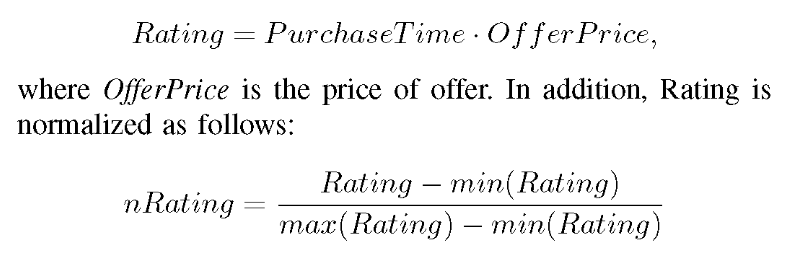https://doi.org/10.1109/ICCE48956.2021.9352111, 2021  (Pham, C. D., Anh Chu, T., Pham, H. H., Linh Dao, M., Pham, T. S., Hung Trinh, V., & Nguyen, D. H. A recommendation system for offers in telecommunications)
- http://www.utstat.toronto.edu/~brunner/DataAnalysisText/Interactions.pdf

### More advanced methods
- Dimension reduction approaches?

### Usage ratings for year-month

In [19]:
pivot_voice_usage_info = pivot_voice_usage_info.drop(['call_count','duration'], axis=1)
pivot_voice_usage_info

,202011.0,202012.0,202101.0,202102.0,202103.0,202104.0,202105.0,202106.0,202107.0
year-month,,,,,,,,,
event_source.hash,,,,,,,,,
59186358517212700922248718974976,30,25,30,25,20,12,16,16,20
000084a38b0fa5ca77e7989aa5eb2d06,16,16,20,20,16,12,16,9,9
0000b72cb5dd05389b70e07ae2eaebd9,16,9,16,16,25,20,16,25,16
0000d6128ae38e7c002db48acdb1515d,4,4,4,16,6,2,1,1,1
0001220457bf95593a9f85d1a00aaa8b,0,0,0,0,0,0,0,9,12
...,...,...,...,...,...,...,...,...,...
fffc95756b7dccbd011d78c8a7d41e6b,0,0,0,0,0,0,0,0,2
fffdd1950a0cc6eb6e701bb732abadac,2,2,4,2,6,9,3,2,2


In [20]:
pivot_voice_usage_info.T.reset_index(drop=True).T
pivot_voice_usage_info.columns=year_month_list

In [21]:
# scaling usage rating
scaler = MinMaxScaler()
for col in year_month_list:
    pivot_voice_usage_info[col] = scaler.fit_transform(pivot_voice_usage_info[col].values.reshape(-1,1))

<AxesSubplot:xlabel='year-month', ylabel='event_source.hash'>

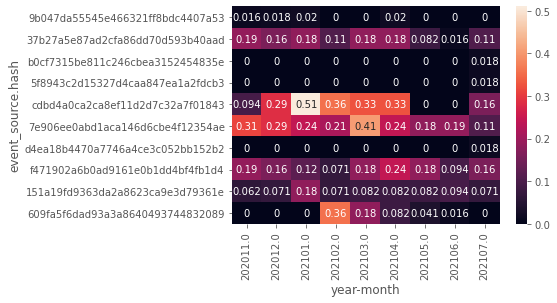

In [22]:
sns.heatmap(pivot_voice_usage_info[year_month_list].sample(n=10), annot=True)

In [23]:
pivot_voice_usage_info['Usage_Rating_Scaled'] = pivot_voice_usage_info[year_month_list].sum(axis=1)/len(year_month_list)
pivot_voice_usage_info

year-month,202011.0,202012.0,202101.0,202102.0,202103.0,202104.0,202105.0,202106.0,202107.0,Usage_Rating_Scaled
event_source.hash,,,,,,,,,,
59186358517212700922248718974976,0.46875,0.446429,0.612245,0.446429,0.408163,0.244898,0.326531,0.250000,0.357143,0.395621
000084a38b0fa5ca77e7989aa5eb2d06,0.25000,0.285714,0.408163,0.357143,0.326531,0.244898,0.326531,0.140625,0.160714,0.277813
0000b72cb5dd05389b70e07ae2eaebd9,0.25000,0.160714,0.326531,0.285714,0.510204,0.408163,0.326531,0.390625,0.285714,0.327133
0000d6128ae38e7c002db48acdb1515d,0.06250,0.071429,0.081633,0.285714,0.122449,0.040816,0.020408,0.015625,0.017857,0.079826
0001220457bf95593a9f85d1a00aaa8b,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140625,0.214286,0.039435
...,...,...,...,...,...,...,...,...,...,...
fffc95756b7dccbd011d78c8a7d41e6b,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.003968
fffdd1950a0cc6eb6e701bb732abadac,0.03125,0.035714,0.081633,0.035714,0.122449,0.183673,0.061224,0.031250,0.035714,0.068736
fffdede40561fb7b84c4c3941dec8e79,0.06250,0.000000,0.000000,0.446429,0.183673,0.183673,0.183673,0.062500,0.071429,0.132653


### Finding Outliers

<AxesSubplot:>

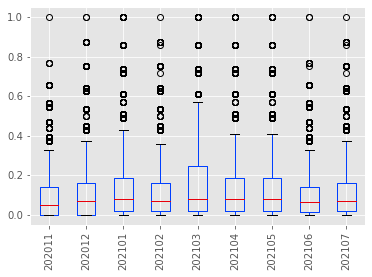

In [24]:
pivot_voice_usage_info.boxplot(column=[int(x) for x in year_month_list], rot=90)

<AxesSubplot:ylabel='year-month'>

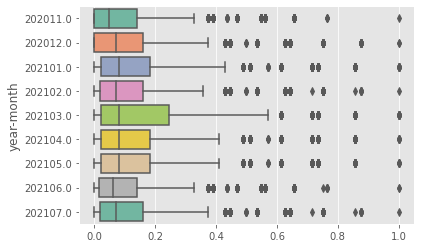

In [25]:
ax = sns.boxplot(data=pivot_voice_usage_info[[int(x) for x in year_month_list]], orient="h", palette="Set2")
ax

<AxesSubplot:ylabel='Density'>

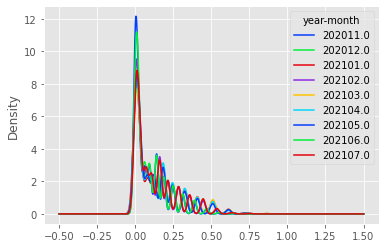

In [26]:
pivot_voice_usage_info[[int(x) for x in year_month_list]].plot(kind = 'density') 

## Three quantitative methods commonly used in statistics for the detection of univariate outliers:
- Tukey’s box plot method
- Internally studentized residuals (AKA z-score method)
- Median Absolute Deviation method

### 1) Tukey’s box plot method
- Tukey distinguishes between possible and probable outliers. A possible outlier is located between the inner and the outer fence, whereas a probable outlier is located outside the outer fence.    
    
- IQR =Q3 - Q1, whereas q3 := 75th quartile and q1 := 25th quartile
- Inner fence = [Q1-1.5*IQR, Q3+1.5*IQR]
- Outer fence = [Q1–3*IQR, Q3+3*IQR]

In [27]:
#Tukey's method
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    outliers_prob_indexes = []
    outliers_poss_indexes = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob_indexes.append(index)
            outliers_prob.append(x)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss_indexes.append(index)
            outliers_poss.append(x)
    # returns indexes of the rows with outliers
    return outliers_prob, outliers_prob_indexes, outliers_poss, outliers_poss_indexes

In [28]:
pr_col_threshold = []
po_col_threshold = []
for col in year_month_list:
    pr_col, pr_col_indexes, po_col, po_col_indexes = tukeys_method(pivot_voice_usage_info, int(col))
    pr_col_threshold.append({col: {"threshold": min(pr_col), "count": len(pr_col)}})
    po_col_threshold.append({col: {"threshold": min(po_col), "count": len(po_col)}})
    print()
    print(f"Probable Outliers for {col}---->\n", pr_col)
    print(len(pr_col))
    print()
    print(f"Possible Outliers for {col}----->\n", po_col)
    print(len(po_col))
    print()


Probable Outliers for 202011.0---->
 [0.65625, 0.5625, 0.5625, 0.65625, 0.65625, 0.5625, 0.5625, 0.65625, 0.65625, 0.5625, 0.5625, 0.5625, 0.5625, 0.65625, 0.5625, 0.65625, 0.65625, 0.5625, 0.65625, 0.65625, 0.5625, 0.765625, 0.5625, 0.5625, 0.5625, 0.65625, 0.5625, 0.5625, 0.5625, 0.5625, 0.65625, 0.5625, 0.5625, 0.5625, 0.65625, 0.5625, 0.65625, 0.5625, 0.5625, 0.65625, 0.5625, 0.5625, 0.5625, 0.65625, 0.5625, 0.65625, 0.65625, 0.5625, 0.5625, 0.5625, 0.65625, 0.65625, 0.65625, 0.765625, 0.65625, 0.5625, 0.5625, 0.65625, 0.5625, 0.65625, 0.5625, 0.65625, 0.65625, 0.5625, 0.5625, 0.65625, 0.65625, 0.65625, 0.5625, 0.5625, 0.5625, 0.765625, 0.65625, 0.65625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.765625, 0.5625, 0.5625, 0.5625, 0.5625, 0.65625, 0.65625, 0.65625, 0.65625, 0.5625, 0.65625, 0.5625, 0.5625, 0.5625, 0.5625, 0.65625, 0.5625, 0.5625, 0.5625, 0.65625, 0.65625, 0.5625, 0.5625, 0.5625, 1.0]
104

Possible Outliers for 202011.0----->
 [0.46875, 0.546875, 0.46875, 0.390625, 0.4

 [0.4464285714285714, 0.4464285714285714, 0.42857142857142855, 0.42857142857142855, 0.5357142857142857, 0.5357142857142857, 0.5357142857142857, 0.42857142857142855, 0.4464285714285714, 0.4464285714285714, 0.4464285714285714, 0.5357142857142857, 0.5357142857142857, 0.4464285714285714, 0.4464285714285714, 0.4464285714285714, 0.5357142857142857, 0.4464285714285714, 0.5357142857142857, 0.4464285714285714, 0.4464285714285714, 0.4464285714285714, 0.4464285714285714, 0.5357142857142857, 0.42857142857142855, 0.6428571428571428, 0.4464285714285714, 0.4464285714285714, 0.4464285714285714, 0.4464285714285714, 0.4464285714285714, 0.4464285714285714, 0.5357142857142857, 0.5357142857142857, 0.4464285714285714, 0.4464285714285714, 0.4464285714285714, 0.4464285714285714, 0.42857142857142855, 0.5357142857142857, 0.4464285714285714, 0.5357142857142857, 0.4464285714285714, 0.4464285714285714, 0.5357142857142857, 0.625, 0.4464285714285714, 0.4464285714285714, 0.4464285714285714, 0.4464285714285714, 0.8571


Possible Outliers for 202105.0----->
 [0.6122448979591836, 0.5102040816326531, 0.6122448979591836, 0.5102040816326531, 0.6122448979591836, 0.5102040816326531, 0.5102040816326531, 0.5102040816326531, 0.4897959183673469, 0.5102040816326531, 0.5102040816326531, 0.5102040816326531, 0.5102040816326531, 0.6122448979591836, 0.6122448979591836, 0.5102040816326531, 0.5102040816326531, 0.6122448979591836, 0.7142857142857142, 0.5102040816326531, 0.6122448979591836, 0.8571428571428571, 0.5102040816326531, 0.5102040816326531, 0.4897959183673469, 0.5102040816326531, 0.5102040816326531, 0.7142857142857142, 0.5102040816326531, 0.5102040816326531, 0.5102040816326531, 0.6122448979591836, 0.4897959183673469, 0.6122448979591836, 0.5102040816326531, 0.5102040816326531, 0.5102040816326531, 0.7142857142857142, 0.5102040816326531, 0.5102040816326531, 0.5102040816326531, 0.5102040816326531, 0.5102040816326531, 0.5102040816326531, 0.5102040816326531, 0.5102040816326531, 0.5102040816326531, 0.5102040816326531, 

In [29]:
pr_col_threshold

[{202011.0: {'threshold': 0.5625, 'count': 104}},
 {202012.0: {'threshold': 0.6428571428571428, 'count': 180}},
 {202101.0: {'threshold': 0.7142857142857142, 'count': 243}},
 {202102.0: {'threshold': 0.625, 'count': 220}},
 {202103.0: {'threshold': 0.9999999999999999, 'count': 15}},
 {202104.0: {'threshold': 0.7142857142857142, 'count': 144}},
 {202105.0: {'threshold': 0.7142857142857142, 'count': 164}},
 {202106.0: {'threshold': 0.546875, 'count': 248}},
 {202107.0: {'threshold': 0.625, 'count': 285}}]

In [30]:
po_col_threshold

[{202011.0: {'threshold': 0.375, 'count': 2218}},
 {202012.0: {'threshold': 0.42857142857142855, 'count': 2937}},
 {202101.0: {'threshold': 0.42857142857142855, 'count': 3170}},
 {202102.0: {'threshold': 0.42857142857142855, 'count': 2640}},
 {202103.0: {'threshold': 0.6122448979591836, 'count': 973}},
 {202104.0: {'threshold': 0.4897959183673469, 'count': 2565}},
 {202105.0: {'threshold': 0.4897959183673469, 'count': 2388}},
 {202106.0: {'threshold': 0.328125, 'count': 2554}},
 {202107.0: {'threshold': 0.375, 'count': 3162}}]

### 2) Median Absolute Deviation method
- this method is highly limited as the distributions mean and standard deviation are sensitive to outliers. This means that finding one outlier is dependent on other outliers as every observation directly affects the mean.    
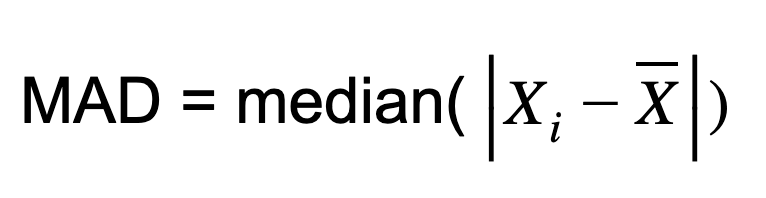

In [31]:
from scipy import stats

# MAD method
def mad_method(df, variable_name):
    #Takes two parameters: dataframe & variable of interest as string
    columns = df.columns
    med = np.median(df, axis = 0)
    mad = np.abs(stats.median_absolute_deviation(df))
    threshold = 3
    outlier = []
    index=0
    for item in range(len(columns)):
        if columns[item] == variable_name:
            index == item
    for i, v in enumerate(df.loc[:,variable_name]):
        t = (v-med[index])/mad[index]
        if t > threshold:
            outlier.append(i)
        else:
            continue
    return outlier

In [32]:
col_threshold = []
for col in year_month_list:
    outliers = mad_method(pivot_voice_usage_info, int(col))
    outlier_cols = pivot_voice_usage_info[int(col)].iloc[outliers]
    col_threshold.append({col: {"threshold" :min(outlier_cols), "count":len(outliers)}})
    print()
    print(f"Outliers for {col}---->\n", outlier_cols)
    print(len(outliers))

<ipython-input-31-ab658f4f8d27>:8: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad = np.abs(stats.median_absolute_deviation(df))



Outliers for 202011.0---->
 event_source.hash
59186358517212700922248718974976    0.468750
000700fc358b7920fab9fd9ea9f93c06    0.546875
000d8f77b0f59f66e4ceb43247503136    0.281250
00126c23e66bff280db1fd5f628a391c    0.312500
002af514a5229bbdf7a8b507d031a335    0.468750
                                      ...   
ffc1a9ad19dee13d434acadcae8ee290    0.468750
ffc1e100097987548c31c656b582413f    0.468750
ffd1fc78dbf8b05c804edef9577e3596    0.312500
ffdf6b918764c6c11d61ebd7bf8c0c54    0.312500
ffe8122c48ddcad2e001c0c3969afe0e    0.281250
Name: 202011.0, Length: 4416, dtype: float64
4416

Outliers for 202012.0---->
 event_source.hash
59186358517212700922248718974976    0.446429
000084a38b0fa5ca77e7989aa5eb2d06    0.285714
000700fc358b7920fab9fd9ea9f93c06    0.535714
000905c3467960583b458ff4e5334288    0.267857
000ff31c70e0974807857ecbd635b641    0.357143
                                      ...   
ffd8538e3aeb8c104882107a14ab3fa2    0.357143
ffdf6b918764c6c11d61ebd7bf8c0c54    0.446429
f

In [33]:
col_threshold

[{202011.0: {'threshold': 0.28125, 'count': 4416}},
 {202012.0: {'threshold': 0.26785714285714285, 'count': 9356}},
 {202101.0: {'threshold': 0.3061224489795918, 'count': 9946}},
 {202102.0: {'threshold': 0.26785714285714285, 'count': 8879}},
 {202103.0: {'threshold': 0.3061224489795918, 'count': 10101}},
 {202104.0: {'threshold': 0.3061224489795918, 'count': 9062}},
 {202105.0: {'threshold': 0.3061224489795918, 'count': 8250}},
 {202106.0: {'threshold': 0.28125, 'count': 4843}},
 {202107.0: {'threshold': 0.26785714285714285, 'count': 9746}}]

In [40]:
sum_outlier = 0
for col in col_threshold:
    for key,val in col.items():
        sum_outlier += val["threshold"]
avg_outlier = sum_outlier / len(col_threshold)
pivot_voice_usage_info["Outlier"]=pivot_voice_usage_info.apply(lambda x : "YES" if x["Usage_Rating_Scaled"]> avg_outlier else "NO", axis=1)
print(avg_outlier)

0.373015873015873


In [34]:
# labling usage bins
bins = [0, 0.18, 0.38,1]
labels = ['LOW','MEDIUM','HIGH']
pivot_voice_usage_info['Usage_Rating_Categorical'] = pd.cut(pivot_voice_usage_info['Usage_Rating_Scaled'], bins=bins, labels=labels)
pivot_voice_usage_info

year-month,202011.0,202012.0,202101.0,202102.0,202103.0,202104.0,202105.0,202106.0,202107.0,Usage_Rating_Scaled,Usage_Rating_Categorical
event_source.hash,,,,,,,,,,,
59186358517212700922248718974976,0.46875,0.446429,0.612245,0.446429,0.408163,0.244898,0.326531,0.250000,0.357143,0.395621,HIGH
000084a38b0fa5ca77e7989aa5eb2d06,0.25000,0.285714,0.408163,0.357143,0.326531,0.244898,0.326531,0.140625,0.160714,0.277813,MEDIUM
0000b72cb5dd05389b70e07ae2eaebd9,0.25000,0.160714,0.326531,0.285714,0.510204,0.408163,0.326531,0.390625,0.285714,0.327133,MEDIUM
0000d6128ae38e7c002db48acdb1515d,0.06250,0.071429,0.081633,0.285714,0.122449,0.040816,0.020408,0.015625,0.017857,0.079826,LOW
0001220457bf95593a9f85d1a00aaa8b,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140625,0.214286,0.039435,LOW
...,...,...,...,...,...,...,...,...,...,...,...
fffc95756b7dccbd011d78c8a7d41e6b,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.003968,LOW
fffdd1950a0cc6eb6e701bb732abadac,0.03125,0.035714,0.081633,0.035714,0.122449,0.183673,0.061224,0.031250,0.035714,0.068736,LOW
fffdede40561fb7b84c4c3941dec8e79,0.06250,0.000000,0.000000,0.446429,0.183673,0.183673,0.183673,0.062500,0.071429,0.132653,LOW


In [35]:
# adding category "NO" 
pivot_voice_usage_info['Usage_Rating_Categorical'] = pivot_voice_usage_info['Usage_Rating_Categorical'].cat.add_categories("NO")
pivot_voice_usage_info.loc[pivot_voice_usage_info['Usage_Rating_Scaled'] == 0.0, 'Usage_Rating_Categorical'] = "NO"
pivot_voice_usage_info[(pivot_voice_usage_info['Usage_Rating_Scaled'] == 0.0)]

year-month,202011.0,202012.0,202101.0,202102.0,202103.0,202104.0,202105.0,202106.0,202107.0,Usage_Rating_Scaled,Usage_Rating_Categorical
event_source.hash,,,,,,,,,,,


### Fina Result: Usage Ratings

In [36]:
pivot_voice_usage_info

year-month,202011.0,202012.0,202101.0,202102.0,202103.0,202104.0,202105.0,202106.0,202107.0,Usage_Rating_Scaled,Usage_Rating_Categorical
event_source.hash,,,,,,,,,,,
59186358517212700922248718974976,0.46875,0.446429,0.612245,0.446429,0.408163,0.244898,0.326531,0.250000,0.357143,0.395621,HIGH
000084a38b0fa5ca77e7989aa5eb2d06,0.25000,0.285714,0.408163,0.357143,0.326531,0.244898,0.326531,0.140625,0.160714,0.277813,MEDIUM
0000b72cb5dd05389b70e07ae2eaebd9,0.25000,0.160714,0.326531,0.285714,0.510204,0.408163,0.326531,0.390625,0.285714,0.327133,MEDIUM
0000d6128ae38e7c002db48acdb1515d,0.06250,0.071429,0.081633,0.285714,0.122449,0.040816,0.020408,0.015625,0.017857,0.079826,LOW
0001220457bf95593a9f85d1a00aaa8b,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140625,0.214286,0.039435,LOW
...,...,...,...,...,...,...,...,...,...,...,...
fffc95756b7dccbd011d78c8a7d41e6b,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.003968,LOW
fffdd1950a0cc6eb6e701bb732abadac,0.03125,0.035714,0.081633,0.035714,0.122449,0.183673,0.061224,0.031250,0.035714,0.068736,LOW
fffdede40561fb7b84c4c3941dec8e79,0.06250,0.000000,0.000000,0.446429,0.183673,0.183673,0.183673,0.062500,0.071429,0.132653,LOW


In [37]:
pivot_voice_usage_info.to_csv("data/user_profile/VOICE_OUTGOING_Usage_Categorical.csv")